# CruisePlan Demo 

This notebook demonstrates the complete CruisePlan workflow using Python functions rather than CLI commands. Each section corresponds to a CLI subcommand and shows how to accomplish the same tasks programmatically.

## Workflow Overview

1. **Download**: Get bathymetry data for depth calculations
2. **Pandoi**: Search PANGAEA database for relevant oceanographic datasets
3. **Pangaea**: Process DOI list into campaign dataset
4. **Stations**: Interactive station planning (or programmatic configuration)
5. **Validate**: Check configuration for errors and warnings
6. **Enrich**: Add computed data (depths, coordinates, expand sections)
7. **Map**: Create visualization maps
8. **Schedule**: Generate cruise timeline and outputs

All outputs will be saved to `tests_output/demo/` for easy exploration.

## Setup and Imports

In [1]:
# Core imports
import logging
from pathlib import Path

import xarray as xr

from cruiseplan.calculators.scheduler import generate_cruise_schedule
from cruiseplan.core.cruise import Cruise
from cruiseplan.core.validation import enrich_configuration
from cruiseplan.data.bathymetry import BathymetryManager
from cruiseplan.data.pangaea import PangaeaManager, save_campaign_data
from cruiseplan.output.map_generator import generate_map_from_yaml
from cruiseplan.utils.global_ports import (
    add_custom_port,
    get_available_ports,
    list_ports_in_region,
)
from cruiseplan.utils.yaml_io import save_yaml

# Set up output directory
output_dir = Path('../tests_output/demo')
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Demo outputs will be saved to: {output_dir.absolute()}")

# Configure logging to see what's happening
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

Demo outputs will be saved to: /Users/eddifying/Cloudfree/github/cruiseplan/notebooks/../tests_output/demo


## Step 1: Download Bathymetry Data

**CLI Equivalent**: `cruiseplan download --bathymetry-source etopo2022`

First, we need bathymetry data for depth calculations and visualization.

In [2]:
# Initialize bathymetry manager with ETOPO2022 data
print("📥 Downloading bathymetry data...")
bathymetry = BathymetryManager(source="etopo2022")

INFO: ✅ Loaded bathymetry from /Users/eddifying/Cloudfree/github/cruiseplan/data/bathymetry/ETOPO_2022_v1_60s_N90W180_bed.nc


📥 Downloading bathymetry data...


## Step 2: Search PANGAEA Database

**CLI Equivalent**: `cruiseplan pandoi "CTD temperature" --lat 50 70 --lon -60 -30 --limit 15`

Search for relevant oceanographic datasets to inform our cruise planning.

In [3]:
print("🔍 Searching PANGAEA database...")

# Initialize PANGAEA manager
pangaea_mgr = PangaeaManager()

# Define search parameters
query = "CTD" # or "CTD temperature North Atlantic"
bbox = (-60, 50, -30, 70)  # (min_lon, min_lat, max_lon, max_lat)
limit = 5

print(f"   Query: '{query}'")
print("   Geographic bounds: 50°N-70°N, 60°W-30°W")
print(f"   Limit: {limit} datasets")

# Perform search
try:
    datasets = pangaea_mgr.search(query=query, bbox=bbox, limit=limit)
    print(f"✅ Found {len(datasets)} datasets")

    # Extract DOIs and save to file
    dois = [ds.get('doi') for ds in datasets if ds.get('doi')]

    # Save DOI list
    doi_file = output_dir / "demo_dois.txt"
    with open(doi_file, 'w') as f:
        for doi in dois:
            f.write(f"{doi}\n")

    print(f"   DOI list saved to: {doi_file}")
    print(f"   First few DOIs: {dois[:3]}")

except Exception as e:
    print(f"❌ Search failed: {e}")
    # Create a minimal DOI list for demo purposes
    doi_file = output_dir / "demo_dois.txt"
    with open(doi_file, 'w') as f:
        f.write("10.1594/PANGAEA.123456\n")
    print(f"   Created minimal DOI file for demo: {doi_file}")

INFO: Searching Pangaea: 'CTD' (Limit: 5)


INFO: Search found 1823 total matches. Retrieving first 5...


🔍 Searching PANGAEA database...
   Query: 'CTD'
   Geographic bounds: 50°N-70°N, 60°W-30°W
   Limit: 5 datasets
✅ Found 5 datasets
   DOI list saved to: ../tests_output/demo/demo_dois.txt
   First few DOIs: ['10.1594/PANGAEA.755512', '10.1594/PANGAEA.604878', '10.1594/PANGAEA.604842']


## Step 3: Process PANGAEA Campaigns

**CLI Equivalent**: `cruiseplan pangaea demo_dois.txt -o tests_output/demo/`

Process the DOI list to extract campaign coordinates and metadata.

In [4]:
# Read the DOI list
with open(output_dir / "demo_dois.txt") as f:
    dois = [line.strip() for line in f if line.strip()]

print(f"📊 Processing {len(dois)} PANGAEA DOIs...")

# Create manager and fetch datasets
manager = PangaeaManager()
datasets = manager.fetch_datasets(
    doi_list=dois,
    rate_limit=1.0,
    merge_campaigns=True
)


if datasets:
    # Save using the CLI's save function
    output_file = Path(output_dir / "ctd_pangaea_data.pkl")
    save_campaign_data(datasets, output_file)
    print(f"✅ Saved {len(datasets)} campaign tracks to {output_file}")
else:
    print("⚠️ No datasets retrieved")

📊 Processing 5 PANGAEA DOIs...


✅ Saved 2 campaign tracks to ../tests_output/demo/ctd_pangaea_data.pkl


## Step 4: Create Station Configuration

**CLI Equivalent**: `cruiseplan stations --pangaea-file campaigns.pkl --lat 50 70 --lon -60 -30`

For this demo, we'll create a programmatic station configuration rather than using the interactive interface.

In [5]:
print("🗺️  Creating station configuration...")

# Create a sample cruise configuration
cruise_config = {
    'cruise_name': 'Demo North Atlantic Survey 2025',
    'default_vessel_speed': 10.0,
    'turnaround_time': 30.0,
    'ctd_descent_rate': 1.0,
    'ctd_ascent_rate': 1.0,
    'calculate_transfer_between_sections': True,
    'calculate_depth_via_bathymetry': True,
    'start_date': '2025-06-01T00:00:00Z',

    # Define stations along a transect
    'stations': [
        {
            'name': 'STN_001',
            'latitude': 55.0,
            'longitude': -50.0,
            'operation_type': 'CTD',
            'action': 'profile',
            'comment': 'Continental shelf station'
        },
        {
            'name': 'STN_002',
            'latitude': 57.0,
            'longitude': -45.0,
            'operation_type': 'CTD',
            'action': 'profile',
            'comment': 'Slope station'
        },
        {
            'name': 'STN_003',
            'latitude': 59.0,
            'longitude': -40.0,
            'operation_type': 'CTD',
            'action': 'profile',
            'comment': 'Deep water station'
        },
        {
            'name': 'STN_004',
            'latitude': 61.0,
            'longitude': -35.0,
            'operation_type': 'water_sampling',
            'action': 'sampling',
            'duration': 180.0,
            'comment': 'Water sampling station'
        },
        {
            'name': 'MOOR_001',
            'latitude': 60.5,
            'longitude': -38.0,
            'operation_type': 'mooring',
            'action': 'deployment',
            'duration': 240.0,
            'comment': 'Mooring deployment'
        },
        {
            'name': 'STN_005',
            'latitude': 63.0,
            'longitude': -30.0,
            'operation_type': 'CTD',
            'action': 'profile',
            'comment': 'Northern end station'
        },
        {
            'name': 'STN_006',
            'latitude': 58.0,
            'longitude': -42.0,
            'operation_type': 'CTD',
            'action': 'profile',
            'comment': 'Return transect station'
        }
    ],

    # Add scientific transit
    'transits': [
        {
            'name': 'Demo_ADCP_Survey',
            'operation_type': 'underway',
            'action': 'ADCP',
            'vessel_speed': 5.0,
            'route': [
                {'latitude': 56.0, 'longitude': -48.0},
                {'latitude': 56.0, 'longitude': -38.0}
            ],
            'comment': 'Zonal ADCP survey transect'
        }
    ],

    # Define execution order with leg-based port definitions
    'legs': [
        {
            'name': 'Demo_Survey',
            'departure_port': 'port_st_johns',
            'arrival_port': 'port_st_johns',
            'first_waypoint': 'STN_001',
            'last_waypoint': 'STN_006',
            'activities': ['STN_001', 'STN_002', 'STN_003', 'Demo_ADCP_Survey', 'STN_004', 'MOOR_001', 'STN_005', 'STN_006']
        }
    ]
}

# Save configuration
config_file = output_dir / "demo_cruise.yaml"
save_yaml(cruise_config, config_file)

print("✅ Station configuration created")
print(f"   Configuration saved to: {config_file}")
print(f"   Stations: {len(cruise_config['stations'])}")
print(f"   Transits: {len(cruise_config['transits'])}")
print(f"   Legs: {len(cruise_config['legs'])}")

INFO: Created backup: ../tests_output/demo/demo_cruise.yaml-7


INFO: Saved configuration to: ../tests_output/demo/demo_cruise.yaml


🗺️  Creating station configuration...
✅ Station configuration created
   Configuration saved to: ../tests_output/demo/demo_cruise.yaml
   Stations: 7
   Transits: 1
   Legs: 1


## Step 5: Manually edit configuration

The cruise configuration in `stations.yaml` will have some default values that need to be manually updated.  These include the `departure_port` and `arrival_port` within the cruise leg definition.  Default values are called "port_update", but can be replaced using values from the catalog of ports.

```yaml
legs:
  - name: Interactive_Survey
    departure_port: port_update
    arrival_port: port_update
    first_waypoint: STN_001
    last_waypoint: STN_002
    strategy: sequential
    activities:
      - STN_001
      - STN_002
      - Transit_01
      - Area_01
```

In [6]:
# Using cruiseplan.utils.global_ports with get_available_ports() and list_ports_in_region()

ports = get_available_ports()

# Display them nicely
for port_id, description in ports.items():
   print(f"{port_id}: {description}")

# Or get ports in a specific region
north_atlantic_ports = list_ports_in_region(
      min_lat=50.0, max_lat=70.0,
      min_lon=-30.0, max_lon=20.0
  )

for port_id, port_name in north_atlantic_ports.items():
    print(f"{port_id}: {port_name}")

# If you want to add a custom port for your project
add_custom_port("port_my_station", {
    "name": "My Research Station",
    "display_name": "My Research Station, Location",
    "latitude": 60.0,
    "longitude": -20.0,
    "timezone": "GMT+0",
    "description": "Custom research station for this cruise"
})

port_reykjavik: Iceland capital, subpolar/Nordic Seas
port_nuuk: Greenland capital, Arctic research gateway
port_tromso: Northern Norway, Arctic gateway
port_trondheim: Central Norway, Norwegian Sea operations
port_bergen: Western Norway, Nordic Seas
port_southampton: UK south coast, Atlantic access
port_bremerhaven: Germany, Arctic and Atlantic operations
port_hamburg: Germany, North Sea and Baltic access
port_emden: Germany, North Sea operations
port_rostock: Germany, Baltic Sea operations
port_kiel: Germany, Baltic Sea research hub
port_brest: France, Atlantic operations
port_nice: France, Mediterranean research
port_vigo: Spain northwest, Atlantic margin research
port_cadiz: Spain southwest, Atlantic and Mediterranean
port_malaga: Spain south coast, Mediterranean research
port_heraklion: Crete, Eastern Mediterranean research
port_catania: Sicily, Mediterranean research
port_limassol: Cyprus, Eastern Mediterranean operations
port_las_palmas: Canary Islands, subtropical Atlantic rese

## Step 5: Enrich Configuration

**CLI Equivalent**: `cruiseplan enrich -c demo_cruise.yaml --add-depths --add-coords --expand-sections`

Add computed data like depths, formatted coordinates, and expand CTD sections.

In [7]:
print("🔧 Enriching configuration...")

config_file = output_dir / "demo_cruise.yaml"
enriched_config_file = output_dir / "demo_cruise_enriched.yaml"

# Use the actual enrichment function
summary = enrich_configuration(
    config_path=config_file,
    add_depths=True,
    add_coords=True,
    expand_sections=True,
    bathymetry_source="etopo2022",
    coord_format="dmm",
    output_path=enriched_config_file
)

print(f"✅ Configuration enriched and saved to {enriched_config_file}")
if summary:
    if summary.get('sections_expanded', 0) > 0:
        print(f"   - Expanded {summary['sections_expanded']} CTD sections")
        print(f"   - Created {summary['stations_from_expansion']} new stations")
    if summary.get('stations_with_depths_added', 0) > 0:
        print(f"   - Added depths to {summary['stations_with_depths_added']} stations")
    if summary.get('stations_with_coords_added', 0) > 0:
        print(f"   - Added coordinates to {summary['stations_with_coords_added']} stations")

INFO: ℹ️ Missing required fields added with defaults. Update these values as needed.


INFO: Saved configuration to: /var/folders/t1/z5bp59k95119nw35yqv699t40000gn/T/tmpiav33_dt.yaml


INFO: ✅ Loaded bathymetry from /Users/eddifying/Cloudfree/github/cruiseplan/data/bathymetry/ETOPO_2022_v1_60s_N90W180_bed.nc


INFO: Created backup: ../tests_output/demo/demo_cruise_enriched.yaml-3


INFO: Saved configuration to: ../tests_output/demo/demo_cruise_enriched.yaml


🔧 Enriching configuration...
✅ Configuration enriched and saved to ../tests_output/demo/demo_cruise_enriched.yaml
   - Added depths to 7 stations
   - Added coordinates to 9 stations


## Step 6: Validate Configuration

**CLI Equivalent**: `cruiseplan validate -c demo_cruise.yaml --check-depths`

Check the configuration for errors and potential issues.

In [8]:
print("✅ Validating configuration...")

config_file = output_dir / "demo_cruise.yaml"
cruise = Cruise(config_file)

# The Cruise.__init__() automatically performs validation during loading
# including Pydantic model validation and cruise-specific validation
print("✅ Configuration loaded and validated successfully!")
print(f"   - Found {len(cruise.station_registry)} station definitions")
print(f"   - Found {len(cruise.config.legs or [])} leg definitions")
if hasattr(cruise.config, 'transits') and cruise.config.transits:
    print(f"   - Found {len(cruise.config.transits)} transit definitions")
if hasattr(cruise.config, 'schedule') and cruise.config.schedule:
    print(f"   - Found {len(cruise.config.schedule)} scheduled items")

✅ Validating configuration...
✅ Configuration loaded and validated successfully!
   - Found 7 station definitions
   - Found 1 leg definitions
   - Found 1 transit definitions


## Step 7: Generate Maps

**CLI Equivalent**: `cruiseplan map -c demo_cruise_enriched.yaml --output-file demo_map.png`

Create visualization maps of the cruise plan.

INFO: Display bounds: 42.6°-68.0°N, -57.7°--25.0°E


🗺️ Generating cruise track map with bathymetry...


INFO: Loading bathymetry for region: 39.6°-71.0°N, -60.7°--22.0°E


INFO: ✅ Loaded bathymetry from /Users/eddifying/Cloudfree/github/cruiseplan/data/bathymetry/GEBCO_2025.nc


INFO: Added bathymetry contours covering full region


INFO: Map displayed with 9 points, 1 lines, 0 areas


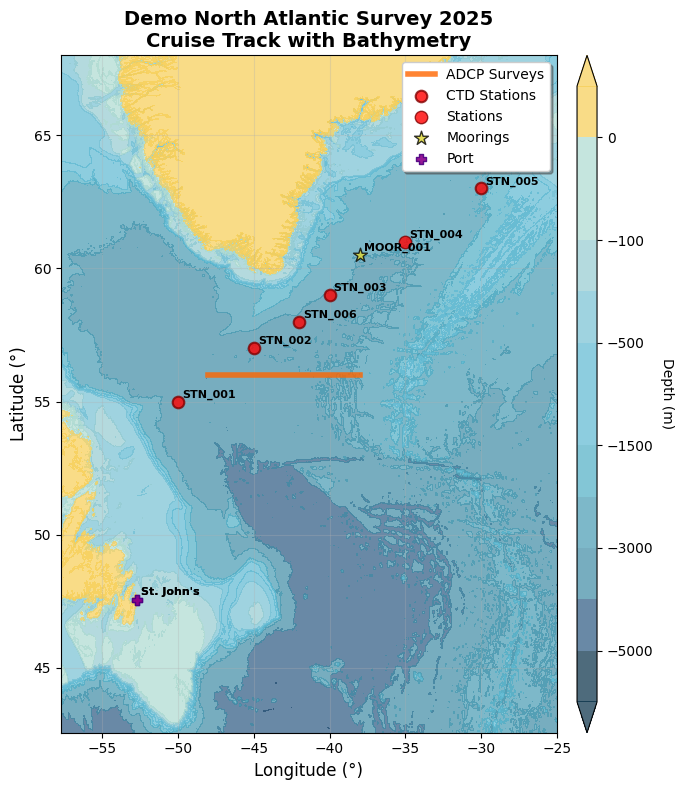

✅ Map generated and displayed


In [9]:
print("🗺️ Generating cruise track map with bathymetry...")

try:
    # Load the enriched cruise configuration
    enriched_config_file = output_dir / "demo_cruise_enriched.yaml"
    cruise = Cruise(enriched_config_file)

    # Generate the map using the new function
    map_file = generate_map_from_yaml(
        cruise,
        output_file="demo_cruise_map.png",
        bathymetry_source="gebco2025",
        bathymetry_stride=5,
        show_plot=True  # Display inline in notebook
    )

    if map_file:
        print("✅ Map generated and displayed")
    else:
        print("❌ Map generation failed")

except Exception as e:
    print(f"❌ Map generation failed: {e}")
    import traceback
    traceback.print_exc()

## Step 8: Generate Schedule

**CLI Equivalent**: `cruiseplan schedule -c demo_cruise_enriched.yaml -o tests_output/demo/ --format all`

Generate the complete cruise timeline and output files.

In [10]:
print("📅 Generating cruise schedule...")

# Generate the schedule with multiple output formats
schedule_results = generate_cruise_schedule(
    config_path=enriched_config_file,
    output_dir=output_dir,
    formats=["html", "csv","netcdf"],  # Available formats: html, csv, latex, netcdf, kml, png
    validate_depths=False,
    selected_leg=None
)

print("✅ Schedule generated successfully!")
if schedule_results:
    for format_type, filepath in schedule_results.items():
        print(f"   - {format_type.upper()}: {filepath}")

INFO: Loaded cruise: Demo North Atlantic Survey 2025


INFO: Generating activity timeline...


INFO: Processing leg 'Demo_Survey': Leg 'Demo_Survey': St. John's (round trip), 0 operations, 1 clusters


INFO: Generated maritime timeline with 17 activities


INFO: - Generated 17 activities


INFO:     Total schedule duration: 390.7 hours


INFO:     Total distance: 3392.2 nm


INFO: - Generating HTML output...


INFO:     HTML schedule: Demo_North_Atlantic_Survey_2025_summary.html


INFO: - Generating CSV output...


INFO:     CSV schedule: Demo_North_Atlantic_Survey_2025_schedule.csv


INFO: - Generating NETCDF output...


INFO:     netCDF output: Demo_North_Atlantic_Survey_2025_schedule.nc


📅 Generating cruise schedule...
✅ Schedule generated successfully!
   - SUCCESS: True
   - TOTAL_ACTIVITIES: 17
   - TOTAL_DURATION_HOURS: 390.71999075468585
   - TOTAL_DISTANCE_NM: 3392.217564026529
   - FORMATS_GENERATED: ['html', 'csv', 'netcdf']
   - OUTPUT_FILES: [PosixPath('../tests_output/demo/Demo_North_Atlantic_Survey_2025_schedule.html'), PosixPath('../tests_output/demo/Demo_North_Atlantic_Survey_2025_schedule.csv'), PosixPath('../tests_output/demo/Demo_North_Atlantic_Survey_2025_schedule.nc')]
   - WARNINGS: []
   - CRUISE_NAME: Demo North Atlantic Survey 2025
   - SELECTED_LEG: None


In [11]:
ds = xr.open_dataset(output_dir / 'Demo_North_Atlantic_Survey_2025_schedule.nc')
ds

<xarray.Dataset> Size: 9kB
Dimensions:          (obs: 17)
Coordinates:
    time             (obs) datetime64[ns] 136B ...
    longitude        (obs) float32 68B ...
    latitude         (obs) float32 68B ...
    waterdepth       (obs) float32 68B ...
Dimensions without coordinates: obs
Data variables: (12/13)
    operation_depth  (obs) float32 68B ...
    name             (obs) <U35 2kB ...
    category         (obs) <U15 1kB ...
    type             (obs) <U23 2kB ...
    action           (obs) <U10 680B ...
    comment          (obs) <U26 2kB ...
    ...               ...
    duration         (obs) float32 68B ...
    vessel_speed     (obs) float32 68B ...
    start_latitude   (obs) float32 68B ...
    start_longitude  (obs) float32 68B ...
    end_latitude     (obs) float32 68B ...
    end_longitude    (obs) float32 68B ...
Attributes:
    featureType:          trajectory
    title:                Ship Schedule: Demo North Atlantic Survey 2025
    institution:          Generated by CruisePlan software
    source:               Scheduler computation from YAML configuration
    Conventions:          CF-1.8
    cruise_name:          Demo North Atlantic Survey 2025
    total_duration_days:  1.04046193882823e-09
    creation_date:        2025-12-20T17:17:39
    comment:              Master file containing all cruise data - specialize...

## Workflow Summary

Let's review what we've accomplished and check our output files.

In [12]:
print("📋 CruisePlan Demo Workflow Complete!")
print("\n🗂️  Generated files in tests_output/demo/:")

# List all files in output directory using pathlib.Path

output_dir = Path(output_dir)  # Ensure output_dir is a Path object
if output_dir.exists():
    files = sorted(output_dir.glob('*'))
    total_size = 0

    for file_path in files:
        if file_path.is_file():
            size = file_path.stat().st_size
            total_size += size
            size_str = f"{size/1024:.1f}KB" if size < 1024*1024 else f"{size/1024/1024:.1f}MB"
            print(f"   📄 {file_path.name:<30} ({size_str})")

    print(f"\n💾 Total output size: {total_size/1024:.1f}KB")
    print(f"📁 Output directory: {output_dir.absolute()}")
else:
    print("   No output files found")

print("\n✨ Workflow Steps Completed:")
steps = [
    "1. ✅ Downloaded bathymetry data (ETOPO2022)",
    "2. ✅ Searched PANGAEA database for relevant datasets",
    "3. ✅ Processed DOI list into campaign data",
    "4. ✅ Created station configuration programmatically",
    "5. ✅ Validated configuration and checked depths",
    "6. ✅ Enriched configuration with computed data",
    "7. ✅ Generated complete cruise schedule and timeline",
    "8. ✅ Created interactive cruise track map"
]

for step in steps:
    print(f"   {step}")

print("\n🎯 Next Steps:")
print("   • Review demo_cruise_schedule.html for the complete cruise timeline")
print("   • Examine demo_cruise_enriched.yaml to see the enriched configuration")
print("   • Import demo_cruise_schedule.nc into data analysis tools")

print("\n🚀 This demonstrates the complete CruisePlan workflow using Python functions!")
print("   Each step corresponds to a CLI command but uses the underlying Python API.")

📋 CruisePlan Demo Workflow Complete!

🗂️  Generated files in tests_output/demo/:
   📄 Demo_North_Atlantic_Survey_2025_schedule.csv (2.4KB)
   📄 Demo_North_Atlantic_Survey_2025_schedule.html (8.1KB)
   📄 Demo_North_Atlantic_Survey_2025_schedule.nc (32.5KB)
   📄 ctd_pangaea_data.pkl           (0.5KB)
   📄 demo_cruise.yaml               (1.8KB)
   📄 demo_cruise.yaml-1             (2.3KB)
   📄 demo_cruise.yaml-2             (2.3KB)
   📄 demo_cruise.yaml-3             (2.3KB)
   📄 demo_cruise.yaml-4             (1.8KB)
   📄 demo_cruise.yaml-5             (1.8KB)
   📄 demo_cruise.yaml-6             (1.8KB)
   📄 demo_cruise.yaml-7             (1.8KB)
   📄 demo_cruise_enriched.yaml      (2.4KB)
   📄 demo_cruise_enriched.yaml-1    (2.4KB)
   📄 demo_cruise_enriched.yaml-2    (2.4KB)
   📄 demo_cruise_enriched.yaml-3    (2.4KB)
   📄 demo_dois.txt                  (0.1KB)

💾 Total output size: 69.1KB
📁 Output directory: /Users/eddifying/Cloudfree/github/cruiseplan/notebooks/../tests_output/demo

✨ 